# Neural Network for GBV (Gender-based violence) Detection

In this notebook we will build a neural network to detect gender violence from tweets.

## Local dependencies

These depedencies are required to run this notebook. You can install them using the following command: `!pip install -r requirements.txt`

In [ ]:
# load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import string
import re
#import fasttext
#import fasttext.util
#ft = fasttext.load_model('cc.es.300.bin') # load fasttext model
import gensim
from imblearn.over_sampling import SMOTE


import nltk

# Télécharger les ressources NLTK nécessaires
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Maintenant, vous pouvez utiliser wordnet
from nltk.corpus import wordnet

syns = wordnet.synsets("program")
for syn in syns:
    print(syn.name(), syn.definition())

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

stemer = PorterStemmer()
lemma = WordNetLemmatizer()

from autocorrect import Speller
speller = Speller()

import contractions

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


plan.n.01 a series of steps to be carried out or goals to be accomplished
program.n.02 a system of projects or services intended to meet a public need
broadcast.n.02 a radio or television show
platform.n.02 a document stating the aims and principles of a political party
program.n.05 an announcement of the events that will occur as part of a theatrical or sporting event
course_of_study.n.01 an integrated course of academic studies
program.n.07 (computer science) a sequence of instructions that a computer can interpret and execute
program.n.08 a performance (or series of performances) at a public presentation
program.v.01 arrange a program of or for
program.v.02 write a computer program


In [ ]:
# Load pre-trained word embeddings

embedding_index = gensim.models.KeyedVectors.load_word2vec_format('../model/cc.es.300.vec')

In [ ]:
# Load dataset

dataset = pd.read_csv('../Datasets/TRAIN_SPANISH.csv')
dataset.head()

,Unnamed: 0,Tweet_ID,tweet,type
0,0,ID_0022DWKP,Tuve un sueño que me violaron anoche.Por un ch...,sexual_violence
1,1,ID_00395QYM,Pensó que la palabra violada significa sexo y ...,sexual_violence
2,2,ID_003EOSSF,"Ella no me habla, fui violado por 2 hombres 1 ...",sexual_violence
3,3,ID_004BBHOD,Fui abusado sexualmente durante 3 años a los 4...,sexual_violence
4,4,ID_004F7516,Play Prout puede hacerlo mejor diciendo la ver...,sexual_violence


In [ ]:
# Dataset shape

dataset.shape

(39650, 4)

## Data preprocessing

We need to preprocess the data before feeding it to the neural network. We will use the following steps to preprocess the data:
1. Check for missing data
2. Check for duplicates
3. Remove special characters (preprocess_text function)

Missing Data Report of each Features : 
Unnamed: 0    0
Tweet_ID      0
tweet         0
type          0
dtype: int64


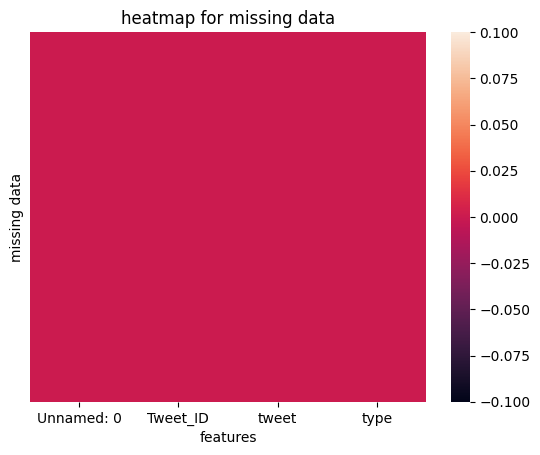

In [ ]:
# Check missing data

print("Missing Data Report of each Features : \n{}".format(dataset.isna().sum()))

sns.heatmap(
    dataset.isna(),
    cbar = 'viridis',
    yticklabels = False
)
plt.xlabel('features')
plt.ylabel('missing data')
plt.title('heatmap for missing data')
plt.show()
plt.close()

In [ ]:
# Check duplicate data

print("Duplicate Records in Dataset : \n{}".format(dataset.duplicated().sum()))

Duplicate Records in Dataset : 
0


In [23]:
# Preprocess text

def preprocess_text(text):
    # convert to lowercase
    text = text.lower()
    # expand contractions
    text = contractions.fix(text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove stopwords
    stop_words = set(stopwords.words('spanish'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    # stemming and lemmatization
    stemmed = [stemer.stem(word) for word in filtered_text]
    lemmatized = [lemma.lemmatize(word) for word in stemmed]
    return ' '.join(lemmatized)

In [ ]:
# Apply preprocess_text function to 'tweet' column

dataset['tweet_preprocessed'] = dataset['tweet'].astype(str).apply(preprocess_text)
dataset.head()

,Unnamed: 0,Tweet_ID,tweet,type,tweet_preprocessed
0,0,ID_0022DWKP,Tuve un sueño que me violaron anoche.Por un ch...,sexual_violence,sueño violaron anochepor chico trabajoen reali...
1,1,ID_00395QYM,Pensó que la palabra violada significa sexo y ...,sexual_violence,pensó palabra violada significa sexo dijo vi p...
2,2,ID_003EOSSF,"Ella no me habla, fui violado por 2 hombres 1 ...",sexual_violence,habla violado hombr abusó cárcel carga así dig...
3,3,ID_004BBHOD,Fui abusado sexualmente durante 3 años a los 4...,sexual_violence,abusado sexualment año año nadi creyófui viola...
4,4,ID_004F7516,Play Prout puede hacerlo mejor diciendo la ver...,sexual_violence,play prout pued hacerlo mejor diciendo verdad ...


In [ ]:
dataset['type'].value_counts()

type
sexual_violence                 32648
Physical_violence                5946
emotional_violence                651
economic_violence                 217
Harmful_Traditional_practice      188
Name: count, dtype: int64

In [ ]:
# Save preprocessed dataset

dataset.to_csv("../Datasets/Preproceses_train.csv")

In [ ]:
dataset = pd.read_csv("../Datasets/Preproceses_train.csv")

## Build Neural Network

In [ ]:
# Categorical data management

# Label encoding
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dataset['label_encode'] = label_encoder.fit_transform(dataset['type'])

In [ ]:
# MLP
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, LSTM, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping


# Tokenize and pad the text
max_words = 10000
maxlen = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(dataset['tweet_preprocessed'])
sequences = tokenizer.texts_to_sequences(dataset['tweet_preprocessed'])
X = pad_sequences(sequences, maxlen=maxlen)
y = dataset['label_encode']
y = to_categorical(y)

In [ ]:
# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
class_names = dataset['type'].unique()

with open('../model/class_names.pickle', 'wb') as handle:
    pickle.dump(class_names, handle)

In [124]:
# Use SMOTE to balance the training set
smote = SMOTE()
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Build the pre-trained model
embedding_dim = 300
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        if word in embedding_index:
            embedding_matrix[i] = embedding_index[word]

# Build the model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen, embeddings_initializer=Constant(embedding_matrix), trainable=True))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names), activation='softmax'))  # Number of classes should match the length of genre_class_names

# Compile the model with a lower learning rate
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Calculate class weights using sklearn
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
class_weights = dict(enumerate(class_weights))

# Manually adjust class weights if needed (optional)
class_weights[4] = class_weights[4] * 2  # Increase the weight for 'economic_violence'

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with class weights
model.fit(X_train_res, y_train_res, epochs=100, batch_size=32, validation_split=0.1, class_weight=class_weights, callbacks=[early_stopping])

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}, Training Loss: {train_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}, Testing Loss: {test_loss:.4f}")

Epoch 1/100


e:\UdeA\Física Computacional 1\proyecto-vbg\venv\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


3675/3675 ━━━━━━━━━━━━━━━━━━━━ 1280s 345ms/step - accuracy: 0.2704 - loss: 21.5533 - val_accuracy: 0.0000e+00 - val_loss: 2.5163
Epoch 2/100
3675/3675 ━━━━━━━━━━━━━━━━━━━━ 1432s 390ms/step - accuracy: 0.3956 - loss: 15.2710 - val_accuracy: 5.3578e-04 - val_loss: 2.0995
Epoch 3/100
3675/3675 ━━━━━━━━━━━━━━━━━━━━ 1439s 391ms/step - accuracy: 0.4332 - loss: 13.5511 - val_accuracy: 0.0628 - val_loss: 2.2594
Epoch 4/100
3675/3675 ━━━━━━━━━━━━━━━━━━━━ 1442s 392ms/step - accuracy: 0.4824 - loss: 11.1557 - val_accuracy: 0.0771 - val_loss: 2.3797
Epoch 5/100
3675/3675 ━━━━━━━━━━━━━━━━━━━━ 1437s 391ms/step - accuracy: 0.5136 - loss: 8.8594 - val_accuracy: 0.1398 - val_loss: 2.0708
Epoch 6/100
3675/3675 ━━━━━━━━━━━━━━━━━━━━ 1435s 390ms/step - accuracy: 0.5462 - loss: 6.9716 - val_accuracy: 0.1491 - val_loss: 2.1400
Epoch 7/100
3675/3675 ━━━━━━━━━━━━━━━━━━━━ 1428s 389ms/step - accuracy: 0.5643 - loss: 5.7058 - val_accuracy: 0.2182 - val_loss: 2.0830
Epoch 8/100
3675/3675 ━━━━━━━━━━━━━━━━━━━━ 1431s

In [77]:
# Save model
model.save('../model/model_.h5')

In [78]:
# Guardar class_weights en un archivo
with open('../model/class_weights_.pickle', 'wb') as handle:
    pickle.dump(class_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [75]:
# Load the saved model
#model = load_model('../model/model.h5')

# Recompile the model with the same optimizer and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Continue training the model with class weights
model.fit(X_train_res, y_train_res, epochs=15, batch_size=32, validation_split=0.1, class_weight=class_weights, callbacks=[early_stopping])

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}, Training Loss: {train_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}, Testing Loss: {test_loss:.4f}")

Epoch 1/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 881s 238ms/step - accuracy: 0.7587 - loss: 2.0909 - val_accuracy: 0.4300 - val_loss: 2.7457
Epoch 2/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1148s 313ms/step - accuracy: 0.7593 - loss: 2.0923 - val_accuracy: 0.4208 - val_loss: 2.7642
Epoch 3/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1144s 311ms/step - accuracy: 0.7633 - loss: 2.0580 - val_accuracy: 0.4120 - val_loss: 2.7360
Epoch 4/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1157s 315ms/step - accuracy: 0.7634 - loss: 1.9357 - val_accuracy: 0.4381 - val_loss: 2.9127
Epoch 5/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1130s 308ms/step - accuracy: 0.7655 - loss: 1.8527 - val_accuracy: 0.4165 - val_loss: 2.8566
Epoch 6/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1138s 310ms/step - accuracy: 0.7679 - loss: 1.9012 - val_accuracy: 0.4610 - val_loss: 2.6927
Epoch 7/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1217s 332ms/step - accuracy: 0.7698 - loss: 1.8690 - val_accuracy: 0.4534 - val_loss: 3.1856
Epoch 8/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 4937s 1s/step 

248/248 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step


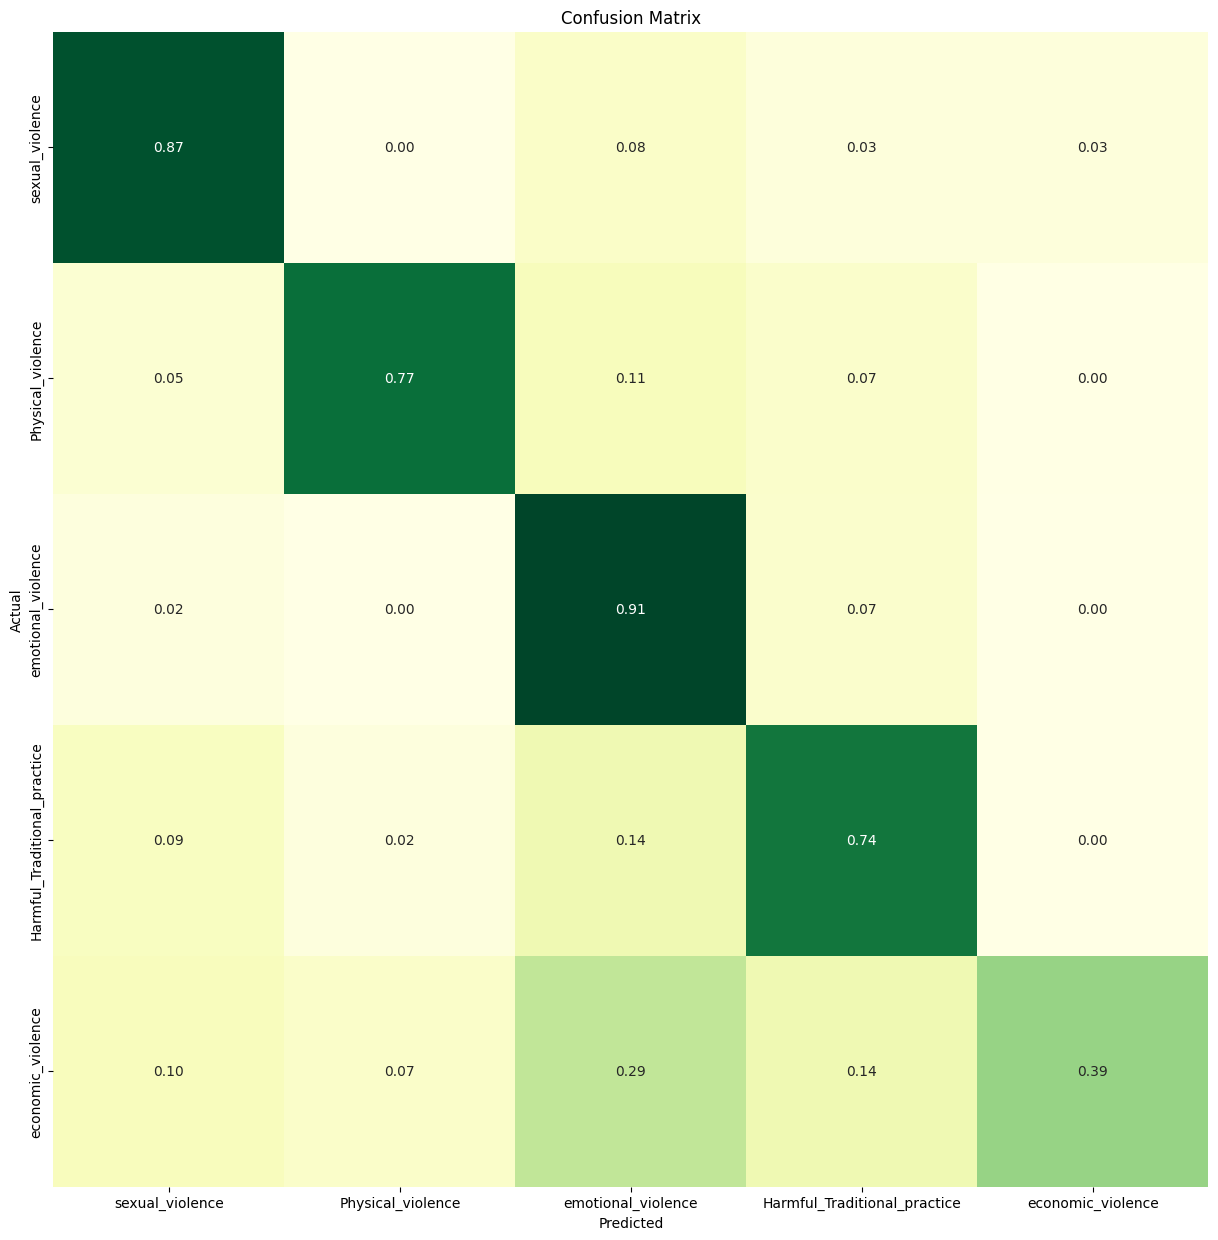

In [76]:
# Load the class names
with open('../model/class_names.pickle', 'rb') as handle:
    class_names = pickle.load(handle)

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Plot the confusion matrix
tick_labels = class_names
fig, ax = plt.subplots(figsize=(15, 15))
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)[:, None]
sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False,
            xticklabels=tick_labels, yticklabels=tick_labels, cmap=plt.cm.YlGn, ax=ax)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.set_title('Confusion Matrix')
plt.show()

In [65]:
# Save model
model.save('../model/model_.h5')

In [66]:
# Guardar class_weights en un archivo
with open('../model/class_weights_.pickle', 'wb') as handle:
    pickle.dump(class_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [67]:
# Load the saved model
#model = load_model('../model/model.h5')

# Recompile the model with the same optimizer and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Continue training the model with class weights
model.fit(X_train_res, y_train_res, epochs=15, batch_size=32, validation_split=0.1, class_weight=class_weights, callbacks=[early_stopping])

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}, Training Loss: {train_loss:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}, Testing Loss: {test_loss:.4f}")

Epoch 1/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1041s 281ms/step - accuracy: 0.7559 - loss: 2.1031 - val_accuracy: 0.4525 - val_loss: 2.7836
Epoch 2/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1162s 317ms/step - accuracy: 0.7579 - loss: 2.0273 - val_accuracy: 0.4102 - val_loss: 2.9204
Epoch 3/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1159s 316ms/step - accuracy: 0.7554 - loss: 2.0832 - val_accuracy: 0.3775 - val_loss: 3.1507
Epoch 4/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1145s 312ms/step - accuracy: 0.7681 - loss: 1.8785 - val_accuracy: 0.4128 - val_loss: 3.0331
Epoch 5/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1141s 311ms/step - accuracy: 0.7628 - loss: 1.9680 - val_accuracy: 0.4014 - val_loss: 3.1525
Epoch 6/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1142s 311ms/step - accuracy: 0.7657 - loss: 1.9850 - val_accuracy: 0.4435 - val_loss: 2.7923
Epoch 7/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1141s 311ms/step - accuracy: 0.7669 - loss: 1.9280 - val_accuracy: 0.4649 - val_loss: 2.8559
Epoch 8/15
3671/3671 ━━━━━━━━━━━━━━━━━━━━ 1140s 310ms/s